In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from scipy.misc import imread, imresize
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:

def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1
        if True:
            print("The {} step.".format(step))
            #print("   h: {}.".format(h))
            #print("   c: {}.".format(c))
            #print("   k: {}.".format(k)) # 5
            #print("   seqs: {}.".format(seqs))
            #print("   embeddings: {}.".format(embeddings))
            print("   incomplete_inds: {}.".format(incomplete_inds))
            print("   complete_inds: {}.".format(complete_inds))
            print("   top_k_scores: {}.".format(top_k_scores))
            print("   k_prev_words: {}.".format(k_prev_words))
            print("   scores size: {}  x {}.".format(len(scores),len(scores[1])))# 5*7003
            print(scores[1])
            #print("   scores : {}.".format(scores ))
            print("   complete_seqs_scores: {}.".format(complete_seqs_scores))
            print("   complete_seqs_alpha: {}.".format(complete_seqs_alpha))
            
    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas




D:\Users\60587\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
D:\Users\60587\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


The 2 step.
   k: 5.
   embeddings: tensor([[ 0.0053,  0.0029, -0.0973,  ..., -0.0441, -0.0429,  0.0252],
        [ 0.0053,  0.0029, -0.0973,  ..., -0.0441, -0.0429,  0.0252],
        [ 0.0053,  0.0029, -0.0973,  ..., -0.0441, -0.0429,  0.0252],
        [ 0.0053,  0.0029, -0.0973,  ..., -0.0441, -0.0429,  0.0252],
        [ 0.0053,  0.0029, -0.0973,  ..., -0.0441, -0.0429,  0.0252]],
       grad_fn=<SqueezeBackward1>).
   incomplete_inds: [0, 1, 2, 3, 4].
   complete_inds: [].
   top_k_scores: tensor([[-0.2122],
        [-3.2907],
        [-3.5259],
        [-3.7777],
        [-3.9067]], grad_fn=<UnsqueezeBackward0>).
   k_prev_words: tensor([[ 28],
        [ 70],
        [ 15],
        [  2],
        [153]]).
   scores size: 5  x 7003.
   complete_seqs_scores: [].
   complete_seqs_alpha: [].
The 3 step.
   k: 5.
   embeddings: tensor([[ 0.1646, -0.0925,  0.0725,  ...,  0.2374,  0.0333,  0.1427],
        [-0.2253, -0.1389,  0.1558,  ..., -0.1009, -0.1628, -0.1112],
        [ 0.1938, -0

   complete_inds: [].
   top_k_scores: tensor([[-8.9573],
        [-8.9992],
        [-9.0152],
        [-9.0640],
        [-9.0875]], grad_fn=<UnsqueezeBackward0>).
   k_prev_words: tensor([[2773],
        [2773],
        [2032],
        [ 311],
        [ 311]]).
   scores size: 5  x 7003.
   complete_seqs_scores: [].
   complete_seqs_alpha: [].
The 12 step.
   k: 2.
   embeddings: tensor([[ 0.1120,  0.1304,  0.0064,  ...,  0.0316, -0.1275,  0.0169],
        [ 0.1120,  0.1304,  0.0064,  ...,  0.0316, -0.1275,  0.0169],
        [-0.0137,  0.0984, -0.1782,  ..., -0.0017, -0.0346,  0.1678],
        [-0.2857,  0.1108,  0.2878,  ...,  0.0754,  0.1612, -0.1385],
        [-0.2857,  0.1108,  0.2878,  ...,  0.0754,  0.1612, -0.1385]],
       grad_fn=<SqueezeBackward1>).
   incomplete_inds: [0, 1].
   complete_inds: [2, 3, 4].
   top_k_scores: tensor([[-9.1095],
        [-9.1287]], grad_fn=<UnsqueezeBackward0>).
   k_prev_words: tensor([[329],
        [329]]).
   scores size: 5  x 7003.
   comp

   complete_seqs_alpha: [[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

it is ok


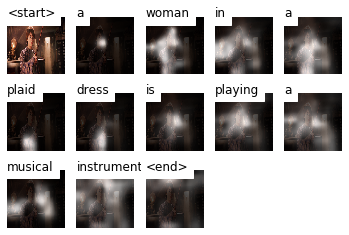

In [27]:

if __name__ == '__main__':  
    
    beam_size=5 
    img='pretrained/test7.jpg'
    smooth = True
    # Load model
    checkpoint = torch.load('pretrained/BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar', map_location=str(device))
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()

    # Load word map (word2ix)
    with open('pretrained/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json', 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

    # Encode, decode with attention and beam search
    seq, alphas = caption_image_beam_search(encoder, decoder, img, word_map, beam_size)
    list_alphas = alphas
    alphas = torch.FloatTensor(alphas)

    # Visualize caption and attention of best sequence
    print ("it is ok")
    visualize_att(img, seq, alphas, rev_word_map, smooth)  # draw: 图像，caption，alphas， 词典， 是否要smooth


    # hiden state： decoder.h

In [26]:
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

In [22]:
print("The seq is: {}".format(seq))
print("The dimension of alphas: {} x {} x {}".format(len(list_alphas), len(list_alphas[1]),len(list_alphas[1][1])))
print("Lenth of word cabulary is:  {}".format(len(rev_word_map)))

The seq is: [7001, 28, 153, 14, 28, 1412, 65, 66, 110, 28, 311, 329, 7002]
The dimension of alphas:13 x 14 x 14
Lenth of word cabulary is 7003


In [ ]:
python caption.py --model='pretrained/BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar' --word_map='pretrained/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json' --beam_size=5 --img='pretrained/test7.jpg'

In [ ]:
def test_photo(img, model='pretrained/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar', word_map ='pretrained/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json', beam_size = 5):
    #parser = argparse.ArgumentParser(description='Show, Attend, and Tell - Tutorial - Generate Caption')
#
    #parser.add_argument('--img', '-i', help='path to image')
    #parser.add_argument('--model', '-m', help='path to model')
    #parser.add_argument('--word_map', '-wm', help='path to word map JSON')
    #parser.add_argument('--beam_size', '-b', default=5, type=int, help='beam size for beam search')
    #parser.add_argument('--dont_smooth', dest='smooth', action='store_false', help='do not smooth alpha overlay')

    #args = parser.parse_args()

    # Load model
    checkpoint = torch.load(model, map_location=str(device))
    decoder = checkpoint['decoder']
    decoder = decoder.to(device) # cpu/GPU
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()

    # Load word map (word2ix)
    with open(word_map, 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

    # Encode, decode with attention and beam search
    seq, alphas = caption_image_beam_search(encoder, decoder, img, word_map, beam_size)
    alphas = torch.FloatTensor(alphas)

    # Visualize caption and attention of best sequence
    #return img, seq, alphas, rev_word_map, 'store_false'
    #return seq, rev_word_map
    sentence = []
    sentence += [rev_word_map[ind] for ind in seq]
    sentence=' '.join(sentence)
    image = Image.open(img)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    '''
    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        #plt.imshow(image)
        current_alpha = alphas[t, :]
        #if smooth:
        alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        #else:
        #    alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t==0:
            plt.imsave('./static/attention/'+str(t)+'.jpg',alpha,alpha=0)
        else:
            plt.imsave('./static/attention/'+str(t)+'.jpg',alpha,alpha=0.8)

        #if t == 0:
            #plt.imshow(alpha, alpha=0)
        #else:
            #plt.imshow(alpha, alpha=0.8)
        #plt.set_cmap(cm.Greys_r)
        #plt.axis('off')
    '''
    #plt.show()
    return sentence
